In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# going to the repository of this note book
%cd drive/My Drive/Thesis/CPNN_PiggyBack
!ls

/content/drive/My Drive/Thesis/CPNN_PiggyBack
data		     iris-model.pickle	performance	   requirements.txt  Untitled0.ipynb
datasets	     lab		push_to_git.ipynb  results
iris-model-full.pth  models		README.md	   run_test


In [3]:
# IMPORT
import torch
import os
# this module is for training and functions related to data preparation
from models.training import *
from models.cpnn import *
# this is for importing pretrain models.
from models.pretrain import *

#from models.cpnn_others import cPNNExp
#from models.cpnn_seq import cPNNSeq
#from models.cgru_double import cGRULinearDouble
#from models.clstm import *

import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy


In [4]:
# EDITABLE PARAMETERS
dataset = "sine_rw10_mode5_extended_6-6_1234"

# OTHER PARAMETERS
batch_size = 128
hidden_size = 50
seq_len = 10
# TODO
iterations = 1
loss_on_seq = False
freeze_inputs_weights = False
pretraining_samples = 0
pretraining_epochs = 0
write_weights = False
combination = False
model_type='GRU'
if model_type == "GRU":
    model_class = PretrainModel
else:
    model_class = cGRULinearDouble

path = os.path.join(
    "performance/pretrain_GRU"
)

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_6-6_1234.csv")
df_task = df[df["task"] == 4]
df_task = df_task.drop(columns="task")

In [ ]:
Model = PretrainModel(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
instance = cPNN(seq_len=seq_len)

In [ ]:
if len(df_task) % batch_size == 0:
  n_batches = int(len(df_task) / batch_size)
else:
  n_batches = int(len(df_task) / batch_size) + 1
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
out_h = None
for j in range(0,5):
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = Model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      loss = loss_fn(y_pred, y)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(Model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[-1.0646, -0.5114],
        [-0.3748, -0.2745],
        [ 0.9363,  0.4935],
        [-0.6167, -0.6726],
        [-1.7827, -0.7076],
        [-0.7806, -0.8862],
        [-1.1246, -0.8216],
        [-0.9595, -0.9613],
        [-1.3106, -0.2168],
        [-0.1666, -0.6756],
        [-0.5746, -1.2564],
        [-0.3997, -0.4646],
        [ 0.1099, -0.7011],
        [-1.3598, -0.4100],
        [-2.3198,  0.4367],
        [-0.5158, -0.1717],
        [-0.7476, -0.7001],
        [ 0.2907,  0.1810],
        [-0.9259, -0.3176],
        [-1.3422, -0.9223],
        [-0.1083, -0.1225],
        [-0.5684, -0.6916],
        [-0.5246, -0.4849],
        [-0.5147, -0.4805],
        [-0.7132,  0.7313],
        [-0.9913, -0.5530],
        [ 0.0045, -0.0460],
        [-0.8345, -0.4271],
        [-1.5715, -0.6312],
        [-1.5486, -0.7335],
        [-1.2113, -0.2738],
        [-1.6185, -0.3948],
        [-1.3173, -1.0987],
        [-0.9327

In [ ]:
# Save model
with open("performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle", "wb") as fp:
    pickle.dump(Model.state_dict(), fp)

## trying to read the weights of the pretrain model

In [ ]:
pretrain_model = PretrainModel(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
with open("performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle", "rb") as fp:
    pretrain_model.load_state_dict(pickle.load(fp),strict=False)

In [ ]:
import statistics

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_16-16_1234.csv")
for task in range(1, df["task"].max() + 1):
  acc=[]
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if len(y) >= seq_len:
        x = np.array(x)
        y = list(y)
        x, y, _ = instance._load_batch(x, y)
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        acc.append(accuracy_score(np.array(y),np.array(pred)))
  print(statistics.mean(acc))


0.35121882992327363
0.20711317135549873
0.6440776854219948
0.8104859335038364


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pretrain_model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[ 4.9395e-01,  7.2624e-01],
        [-2.5023e-01, -1.5779e+00],
        [ 4.2910e-02, -2.2821e-03],
        [-2.7951e-01, -9.4084e-02],
        [-4.2295e-01, -2.2655e-01],
        [-7.1322e-01, -6.1827e-01],
        [-1.0246e-02, -3.2005e-01],
        [-4.1410e-01, -1.2440e+00],
        [-7.2617e-01, -7.9609e-01],
        [-5.6529e-01, -9.9232e-01],
        [-5.3829e-01, -1.3724e+00],
        [-4.4110e-01, -1.1477e+00],
        [-4.6161e-01, -9.9819e-01],
        [-3.8753e-01,  8.9283e-01],
        [-6.3671e-01, -1.5068e+00],
        [-7.4016e-01, -1.4635e+00],
        [-2.6262e-01, -5.4108e-02],
        [-8.1440e-01, -1.1812e+00],
        [-2.4015e-01, -5.9275e-01],
        [-7.2938e-01, -1.5080e+00],
        [ 1.7937e-01,  2.7415e-01],
        [-4.2030e-01, -5.6660e-01],
        [-5.5590e-01, -5.9604e-01],
        [-5.3422e-01, -5.8739e-01],
        [-3.8810e-01,  2.8452e-01],
        [-9.4800e-02,  7.1795e-01],
    

In [ ]:
pretrain_model

PretrainModel(
  (gru): GRU(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
x = copy.deepcopy(pretrain_model.state_dict())
for param_name in x:
  print(param_name)
  print(x[param_name].shape)

gru.weight_ih_l0
torch.Size([150, 2])
gru.weight_hh_l0
torch.Size([150, 50])
gru.bias_ih_l0
torch.Size([150])
gru.bias_hh_l0
torch.Size([150])
linear.weight
torch.Size([2, 50])
linear.bias
torch.Size([2])


In [19]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
acc=[]
kappa=[]
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())
      for j in range(0,5):
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)


In [20]:
print(acc[0])
print(acc[1])
print(acc[2])
print(acc[3])

[0.484375, 0.5, 0.671875, 0.6484375, 0.6796875, 0.6484375, 0.6015625, 0.8046875, 0.859375, 0.671875, 0.6875, 0.7265625, 0.7890625, 0.7734375, 0.75, 0.640625, 0.8203125, 0.8828125, 0.75, 0.609375, 0.7109375, 0.796875, 0.8125, 0.8203125, 0.7734375, 0.7265625, 0.765625, 0.4140625, 0.640625, 0.640625, 0.765625, 0.7578125, 0.625, 0.703125, 0.8671875, 0.6796875, 0.5703125, 0.828125, 0.65625, 0.7578125, 0.90625, 0.5625, 0.859375, 0.7109375, 0.6328125, 0.75, 0.640625, 0.640625, 0.84375, 0.6953125, 0.78125, 0.796875, 0.796875, 0.75, 0.71875, 0.828125, 0.8203125, 0.8828125, 0.8671875, 0.828125, 0.7890625, 0.7734375, 0.890625, 0.8515625, 0.8515625, 0.7890625, 0.8828125, 0.859375, 0.8203125, 0.625, 0.7890625, 0.7890625, 0.75, 0.828125, 0.59375, 0.765625, 0.7265625, 0.6953125, 0.59375, 0.859375, 0.8125, 0.875, 0.6640625, 0.6953125, 0.84375, 0.671875, 0.7578125, 0.734375, 0.8515625, 0.8515625, 0.8984375, 0.8671875, 0.828125, 0.765625, 0.8125, 0.6484375, 0.5078125, 0.5234375, 0.6796875, 0.8515625, 0.

In [21]:
pd.DataFrame(acc).to_csv('results/acc-16_16-2341-puretrain.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-16_16-2341-puretrain.csv', index=False)

#**From now on, the part for adding mask will be implemented:**

##The first part is the implementing of the frozen pretrained model and then testing on test dataset.

In [4]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle'

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
with open(pretrain_model_addr, "rb") as fp:
    		    pretrain_model.load_state_dict(pickle.load(fp),strict=False)
acc=[]
kappa=[]
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())


In [5]:
pd.DataFrame(acc).to_csv('results/acc-CPB-16_16-frozen-1234-t4.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-CPB-16_16-frozen-1234-t4.csv', index=False)

0    0.668472
1    0.700355
2    0.656562
3    0.812521
4    0.666689
dtype: float64
0    0.658617
1    0.674011
2    0.670207
3    0.794875
4    0.687306
dtype: float64
0    0.663672
1    0.640572
2    0.658128
3    0.719156
4    0.803571
dtype: float64
0    0.658728
1    0.641481
2    0.670671
3    0.705178
4    0.805178
dtype: float64


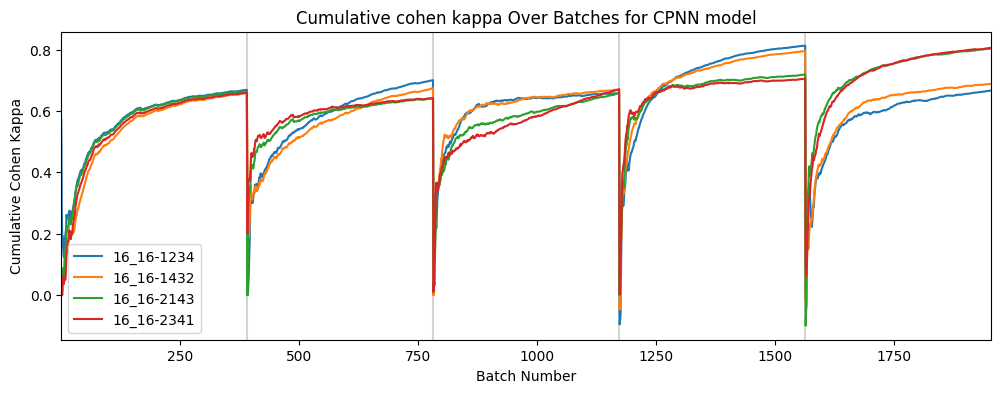

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1234.csv'))
df2 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1432.csv'))
df3 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2143.csv'))
df4 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2341.csv'))

def string_to_float(s):
    return float(s.strip('[]'))

# Apply the conversion function to each element in the array
df1 = pd.DataFrame(np.vectorize(string_to_float)(df1))
df2 = pd.DataFrame(np.vectorize(string_to_float)(df2))
df3 = pd.DataFrame(np.vectorize(string_to_float)(df3))
df4 = pd.DataFrame(np.vectorize(string_to_float)(df4))
# Create a DataFrame from the converted data
print( df1.mean(axis=1))
print( df2.mean(axis=1))
print( df3.mean(axis=1))
print( df4.mean(axis=1))

all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1],4*all_x.shape[1]]
x = list(range(1,5*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],5):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3],y[i+4]),axis=0), label= label_list[int(i/5)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative cohen kappa Over Batches for CPNN model')
plt.legend()
plt.show()

##Now we also train the pretrain model for each task of the test dataset.

list of accuracies that used for evaluating and selecting the models =  [0.72]
list of kappa values that used for evaluating and selecting the models =  [0.43945096]
index of selcted mask for this task 0
All batches Accuracy=  0.7993046675191816
All batches cohen kappa=  0.5982083318197666
list of accuracies that used for evaluating and selecting the models =  [0.73015625 0.84      ]
list of kappa values that used for evaluating and selecting the models =  [0.46699681 0.66984547]
index of selcted mask for this task 1
All batches Accuracy=  0.8656769501278773
All batches cohen kappa=  0.7294328659772873
list of accuracies that used for evaluating and selecting the models =  [0.78015625 0.8865625  0.87609375]
list of kappa values that used for evaluating and selecting the models =  [0.55729949 0.76786686 0.74810469]
index of selcted mask for this task 1
All batches Accuracy=  0.8562579923273658
All batches cohen kappa=  0.7097696384410267
list of accuracies that used for evaluating and s

All batches Accuracy=  0.8630554667519181
All batches cohen kappa=  0.7218068554149488


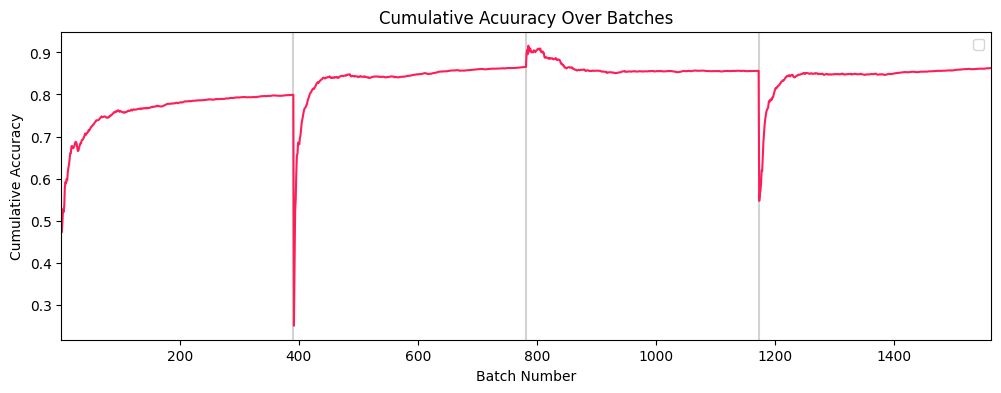

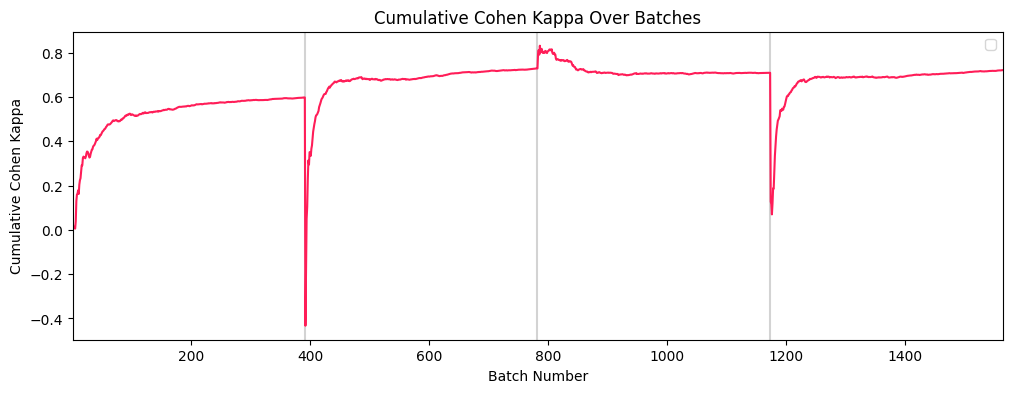

In [14]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr , seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


list of accuracies that used for evaluating and selecting the models =  [0.66828125]
list of kappa values that used for evaluating and selecting the models =  [0.36277761]
index of selcted mask for this task 0
All batches Accuracy=  0.8158367966751918
All batches cohen kappa=  0.6327935671587885
list of accuracies that used for evaluating and selecting the models =  [0.75015625 0.81328125]
list of kappa values that used for evaluating and selecting the models =  [0.49699589 0.61649768]
index of selcted mask for this task 1
All batches Accuracy=  0.8334918478260869
All batches cohen kappa=  0.6643425897907114
list of accuracies that used for evaluating and selecting the models =  [0.72046875 0.87234375 0.8790625 ]
list of kappa values that used for evaluating and selecting the models =  [0.4490599  0.74091179 0.75317699]
index of selcted mask for this task 2
All batches Accuracy=  0.8668718030690536
All batches cohen kappa=  0.73151252222488
list of accuracies that used for evaluating a

All batches Accuracy=  0.8283687659846547
All batches cohen kappa=  0.6538821482826072


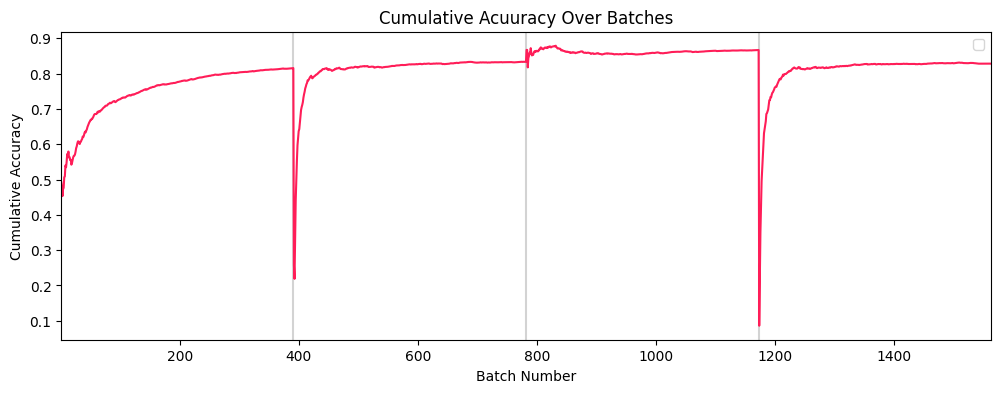

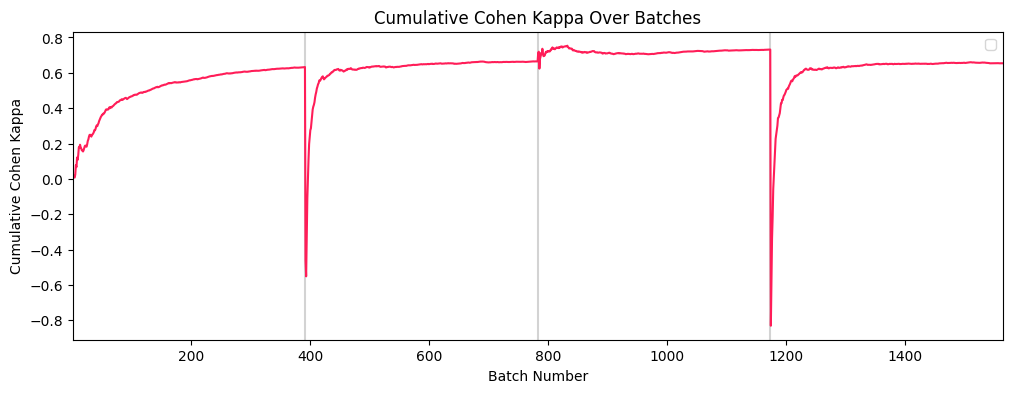

In [6]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1432"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_1.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr , seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [7]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-1432-t1.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-1432-t1.csv', index=False)

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-16_16-1234-4.csv'))
df2 = np.array(pd.read_csv('results/kappa-16_16-1432-4.csv'))
df3 = np.array(pd.read_csv('results/kappa-16_16-2143-4.csv'))
df4 = np.array(pd.read_csv('results/kappa-16_16-2341-4.csv'))
all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1]]
x = list(range(1,4*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],4):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3]),axis=0), label= label_list[int(i/4)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative Cohen Kappa Over Batches')
plt.legend()
plt.show()